In [1]:
from keras.layers import Input, Dense, Lambda, Layer, Multiply, Add
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

Using TensorFlow backend.


In [2]:
batch_size = 100
original_dim = 784 #(28x28)
latent_dim = 2
intermediate_dim  = 256
epochs = 15

In [3]:
#plot_model(decoder, show_shapes=True, show_layer_names=True)

In [4]:
class KLDivergenceLayer(Layer):
    #keras layerként jelenik meg

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [5]:
x = Input(shape=(original_dim,))

# rejtett réteg
h = Dense(intermediate_dim, activation='relu')(x)

# kimeneti réteg: átlag és a variancia logaritmusa
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0],latent_dim)))

z_eps = Multiply()([z_sigma,eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = decoder(z)

In [6]:
# a hibafüggvény most egyéni lesz: negatív log-likelihood

# log_pθ(x|z)
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [7]:
vae = Model(inputs=[x,eps], outputs=x_pred)

In [8]:
vae.compile(optimizer='rmsprop',loss=nll)

In [9]:
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
____________________________________________________________________________________________

In [10]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [11]:
x_train = x_train.reshape(-1, original_dim) /255

In [12]:
x_test = x_test.reshape(-1, original_dim) /255

In [13]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 8s 132us/step - loss: 190.7942 - val_loss: 172.8404
Epoch 2/15
60000/60000 [==============================] - 7s 114us/step - loss: 170.7208 - val_loss: 168.6580
Epoch 3/15
60000/60000 [==============================] - 7s 117us/step - loss: 167.3901 - val_loss: 166.4246
Epoch 4/15
60000/60000 [==============================] - 7s 115us/step - loss: 165.2500 - val_loss: 164.2792
Epoch 5/15
60000/60000 [==============================] - 7s 123us/step - loss: 163.6675 - val_loss: 163.2336
Epoch 6/15
60000/60000 [==============================] - 7s 121us/step - loss: 162.4351 - val_loss: 161.9710
Epoch 7/15
60000/60000 [==============================] - 7s 116us/step - loss: 161.3612 - val_loss: 161.0031
Epoch 8/15
60000/60000 [==============================] - 7s 118us/step - loss: 160.3656 - val_loss: 159.8547
Epoch 9/15
60000/60000 [==============================] - 7s 116us/ste

In [14]:
encoder = Model(x, z_mu)
encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
____________________________________________________________________________________________

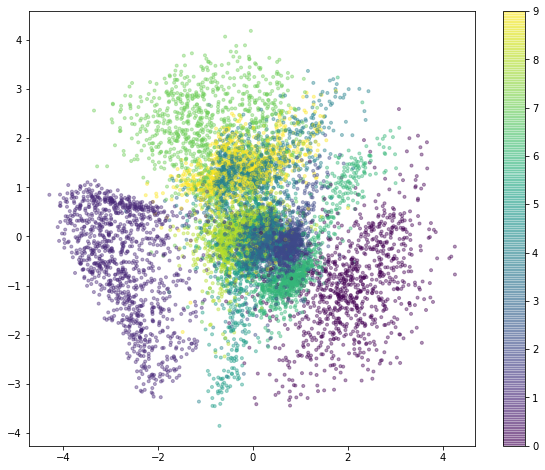

In [15]:

z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 8))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [16]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


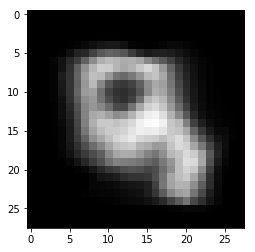

In [17]:
xz_sample = norm.ppf(np.random.rand(1,2))
#print (z_sample.shape)
z_sample=np.array([[0.9, 0.9]])
#print (z_sample.shape)
#print(z_sample)
generated_digit = decoder.predict(z_sample)
plt.imshow(generated_digit.reshape(28,28), cmap='gray')
plt.show()

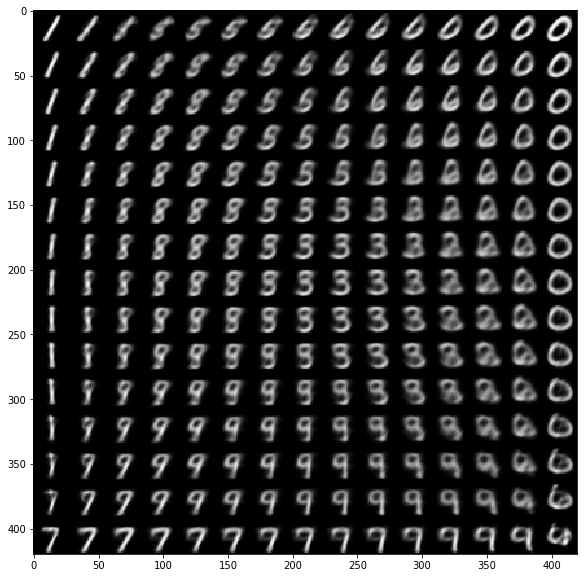

In [18]:
# digitek 2D síkon ábrázolva
n = 15  # 15x15 digit
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))

z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()